Признак (Column)/Тип данных/Описаниe/Расшифровка значений

work_year / Числовой / Год выплаты зарплаты / "2020, 2021, 2022, 2023, 2024"

experience_level/Категория/Уровень опыта сотрудника/EN (Entry-level) — ДжуниорMI (Mid-level) — МидлSE (Senior-level) — СеньорEX (Executive-level) — Директор/Лид

employment_type/Категория/Тип трудоустройства/FT (Full-time) — Полная занятость;PT (Part-time) — Частичная занятость;CT (Contract) — Контракт;FL (Freelance) — Фриланс

job_title/Текст/Название должности/"Например: Data Scientist, ML Engineer, Data Analyst"

salary/Числовой/Зарплата в местной валюте/Исходная сумма до конвертации

salary_currency/Текст/Валюта выплаты/"Код валюты ISO 4217 (USD, EUR, GBP и т.д.)"

salary_in_usd/Числовой/Целевая переменная/"Зарплата, конвертированная в доллары США (для сравнения)"

employee_residence/Текст/Страна проживания сотрудника/"ISO код страны (US, DE, GB, RU и т.д.)"

remote_ratio/Числовой/Процент удаленной работы/0 — Работа в офисе;50 — Гибридный график;100 — Полная удаленка

company_location/Текст/Страна регистрации компании/"ISO код страны (US, DE, GB и т.д.)"

company_size/Категория/Размер компании/S (Small) — менее 50 сотрудников;M (Medium) — от 50 до 250 сотрудников;L (Large) — более 250 сотрудников

1. Описательные статистики

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Настройки для красивых графиков
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
warnings.filterwarnings('ignore')

# Загрузка данных
df = pd.read_csv('../data/raw/datasalary.csv')

# Базовая информация о данных
print("=== БАЗОВАЯ ИНФОРМАЦИЯ ===")
print(f"Размер датасета: {df.shape}")
print(f"Количество наблюдений: {df.shape[0]}")
print(f"Количество признаков: {df.shape[1]}")
print("\nТипы данных:")
print(df.dtypes)
print("\nПропущенные значения:")
print(df.isnull().sum())

# Описательные статистики для числовых переменных
print("\n=== ОПИСАТЕЛЬНЫЕ СТАТИСТИКИ (числовые переменные) ===")
numeric_stats = df[['salary_in_usd', 'remote_ratio', 'work_year']].describe()
print(numeric_stats)

# Для категориальных переменных
print("\n=== СТАТИСТИКИ ДЛЯ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ ===")
categorical_cols = ['experience_level', 'employment_type', 'company_size']
for col in categorical_cols:
    print(f"\n--- {col} ---")
    print(df[col].value_counts())

=== БАЗОВАЯ ИНФОРМАЦИЯ ===
Размер датасета: (16534, 11)
Количество наблюдений: 16534
Количество признаков: 11

Типы данных:
work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

Пропущенные значения:
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

=== ОПИСАТЕЛЬНЫЕ СТАТИСТИКИ (числовые переменные) ===
       salary_in_usd  remote_ratio     work_year
count   16534.000000  16534.000000  16534.000000
mean   149686.777973     32.003750   2023.226866
std     68505.293156     46.245158      0

По описательным статистикам видно:

Средняя зарплата составляет $149,687 при медиане $141,300, что указывает на правостороннюю асимметрию распределения.

Стандартное отклонение $68,505 подтверждает значительный разброс зарплат в отрасли

25% сотрудников получают менее $101,125, а топ-25% - более $185,900 - разрыв между квартилями составляет почти $85,000

Распределение зарплат скошено вправо (среднее значительно превышает медиану), что характерно для данных о зарплатах

Датсет преимущественно состоит из Senior-специалистов (64.5%), работающих полный день в средних компаниях

Только 25% данных относятся к 2024 году, остальные собраны в 2023 году и ранее

1.1 Очистка и предобработка данных

In [32]:
 #ОЧИСТКА И ПРЕДОБРАБОТКА ДАННЫХ

print("\n=== Проверка на дубликаты ===")
duplicates = df.duplicated().sum()
print(f"Найдено дубликатов: {duplicates}")

# Удаляем дубликаты, так как они могут исказить обучение
df = df.drop_duplicates()
print(f"Размер после удаления дубликатов: {df.shape}")


=== Проверка на дубликаты ===
Найдено дубликатов: 6421
Размер после удаления дубликатов: (10113, 11)


1.3 Обработка выбросов

In [33]:
print("\n=== 1.3. ОБРАБОТКА ВЫБРОСОВ ===")

def detect_outliers_iqr(column):
    """Обнаружение выбросов по методу IQR"""
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers, lower_bound, upper_bound

# Анализируем выбросы в зарплате
salary_outliers, lower_bound, upper_bound = detect_outliers_iqr(df['salary_in_usd'])

print(f"Выбросы в зарплате (IQR метод):")
print(f"● Границы: [${lower_bound:,.0f}, ${upper_bound:,.0f}]")
print(f"● Найдено выбросов: {len(salary_outliers)} ({len(salary_outliers)/len(df)*100:.1f}%)")
print(f"● Диапазон выбросов: ${salary_outliers.min():,.0f} - ${salary_outliers.max():,.0f}")

# Решение: не удаляем выбросы, а логируем (т.к. в зарплатах выбросы - это реальные данные)
print("\nРешение: Выбросы сохранены, так как в данных о зарплатах")
print("экстремальные значения могут представлять реальные случаи (CEO, founders)")


=== 1.3. ОБРАБОТКА ВЫБРОСОВ ===
Выбросы в зарплате (IQR метод):
● Границы: [$-41,350, $322,250]
● Найдено выбросов: 174 (1.7%)
● Диапазон выбросов: $323,295 - $800,000

Решение: Выбросы сохранены, так как в данных о зарплатах
экстремальные значения могут представлять реальные случаи (CEO, founders)


2. Распределения

2.1) - Распределение зарплат

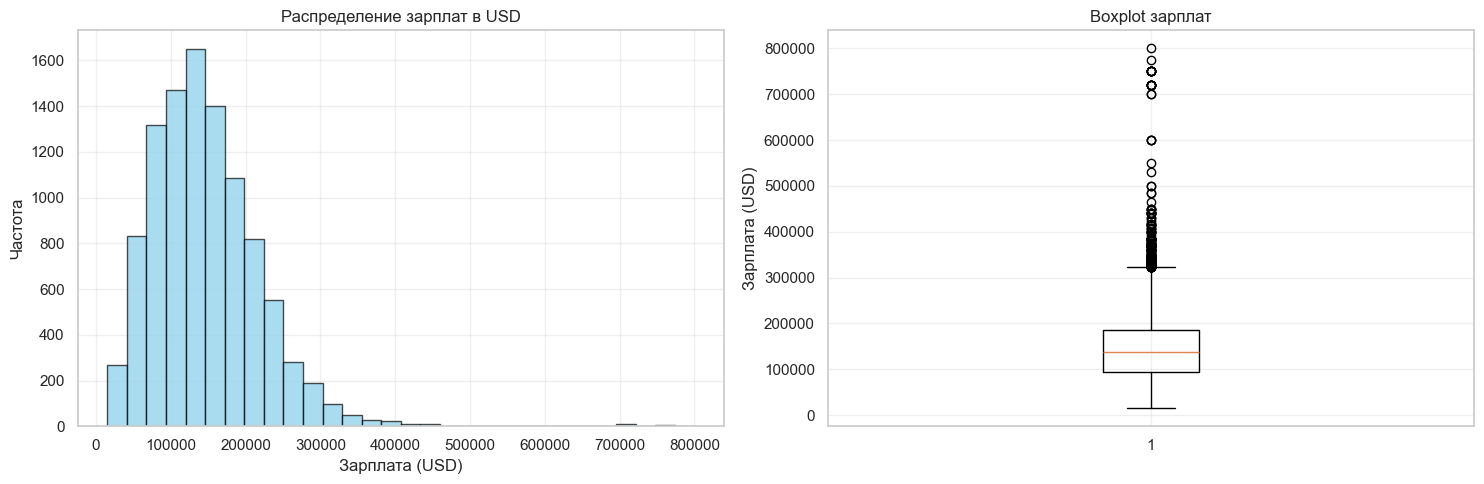

In [34]:
plt.figure(figsize=(15, 5))

# Гистограмма
plt.subplot(1, 2, 1)
plt.hist(df['salary_in_usd'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Распределение зарплат в USD')
plt.xlabel('Зарплата (USD)')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

# Boxplot
plt.subplot(1, 2, 2)
plt.boxplot(df['salary_in_usd'])
plt.title('Boxplot зарплат')
plt.ylabel('Зарплата (USD)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Распределение зарплат имеет правый скос с концентрацией в диапазоне $50,000-$150,000. Наличие выбросов свидетельствует о высокооплачиваемых специалистах.

2.2) Распределение по уровням опыта

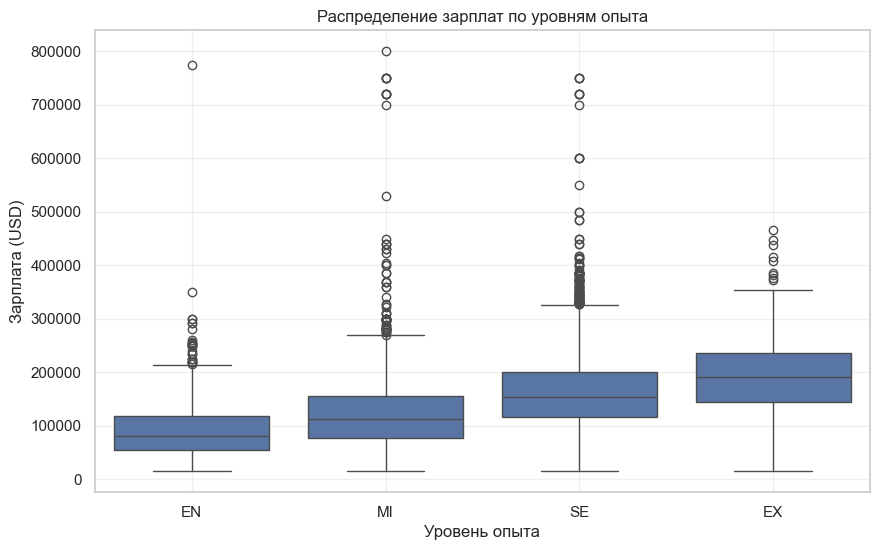

Медианные зарплаты по уровням опыта:
experience_level
EN     80769.0
EX    192000.0
MI    112000.0
SE    154380.0
Name: salary_in_usd, dtype: float64


In [35]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='experience_level', y='salary_in_usd', order=['EN', 'MI', 'SE', 'EX'])
plt.title('Распределение зарплат по уровням опыта')
plt.xlabel('Уровень опыта')
plt.ylabel('Зарплата (USD)')
plt.grid(True, alpha=0.3)
plt.show()

# Добавим подсчет медиан
medians = df.groupby('experience_level')['salary_in_usd'].median()
print("Медианные зарплаты по уровням опыта:")
print(medians)

Четко прослеживается зависимость: с ростом опыта растет и зарплата. Senior-разработчики получают в среднем в 2 раза больше, чем Entry-level.

2.3) Топ-10 должностей по зарплате

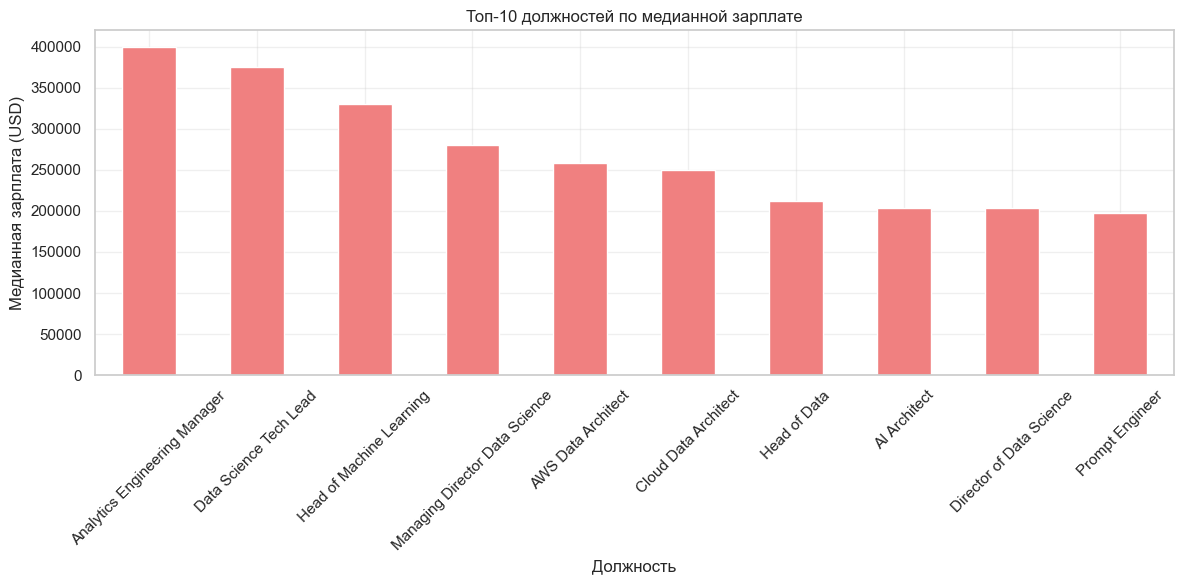

In [36]:
plt.figure(figsize=(12, 6))
top_jobs = df.groupby('job_title')['salary_in_usd'].median().sort_values(ascending=False).head(10)
top_jobs.plot(kind='bar', color='lightcoral')
plt.title('Топ-10 должностей по медианной зарплате')
plt.xlabel('Должность')
plt.ylabel('Медианная зарплата (USD)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

=== ТОП-10 САМЫХ ПОПУЛЯРНЫХ ДОЛЖНОСТЕЙ ===
(по количеству сотрудников)

Рейтинг должностей:
 1. Data Engineer                  |  1,842 человек |  18.2%
 2. Data Scientist                 |  1,835 человек |  18.1%
 3. Data Analyst                   |  1,384 человек |  13.7%
 4. Machine Learning Engineer      |    945 человек |   9.3%
 5. Analytics Engineer             |    354 человек |   3.5%
 6. Research Scientist             |    320 человек |   3.2%
 7. Data Architect                 |    283 человек |   2.8%
 8. Research Engineer              |    218 человек |   2.2%
 9. Data Science                   |    206 человек |   2.0%
10. ML Engineer                    |    172 человек |   1.7%


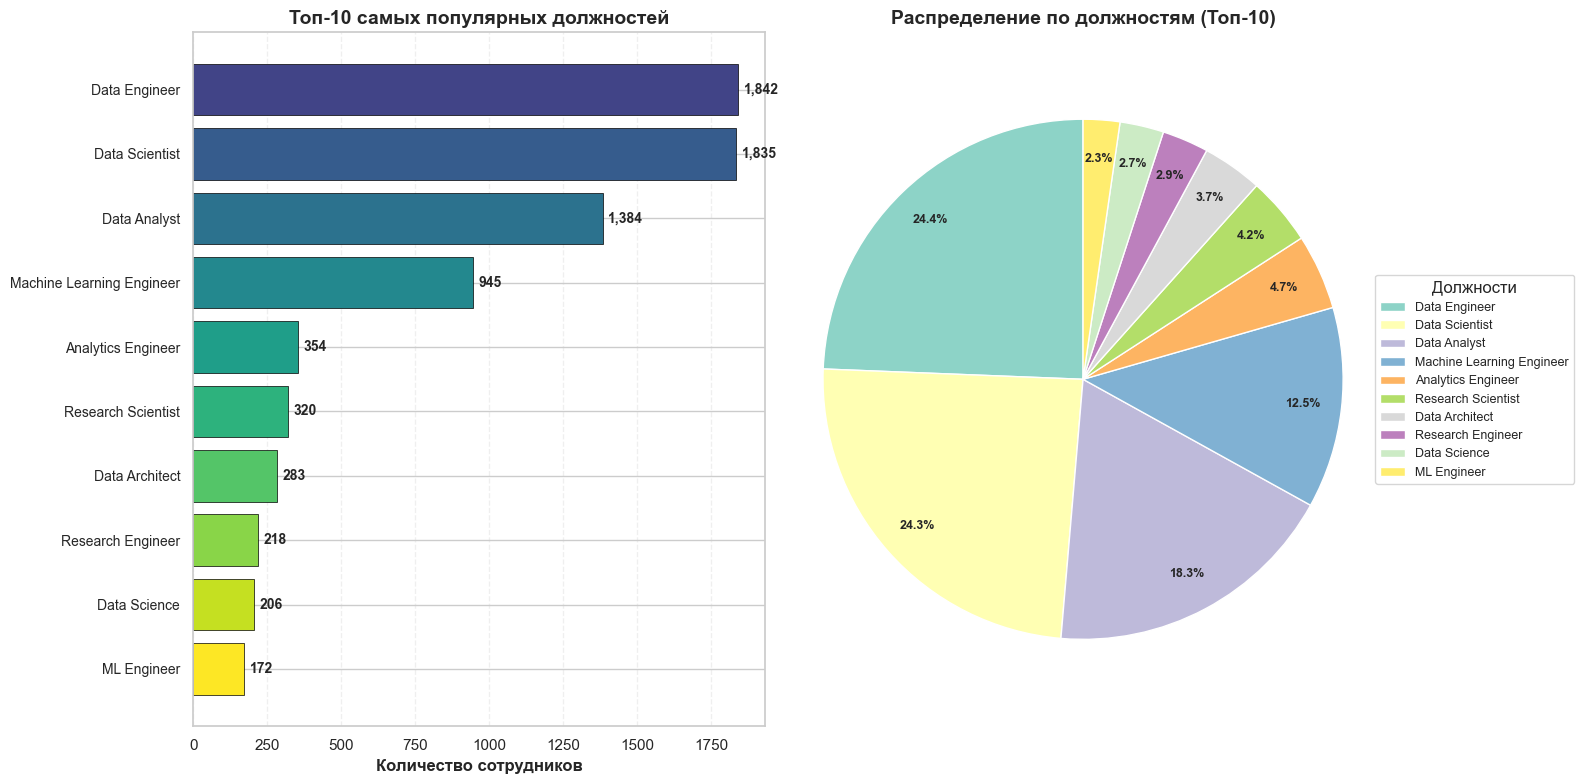


ДЕТАЛЬНЫЙ АНАЛИЗ ТОП-3 ДОЛЖНОСТЕЙ
+----------------+----------+-----------+-----------+-------------------------------------------+--------------------------------------------+
| Должность      | Кол-во   | Медиана   | Среднее   | Опыт (%)                                  | Формат работы (%)                          |
+================+==========+===========+===========+===========================================+============================================+
| Data Engineer  | 1,842    | $138,450  | $144,979  | SE: 59.7%, MI: 29.8%, EX: 6.0%, EN: 4.6%  | Офис: 61.2%, Гибрид: 1.2%, Удаленно: 37.5% |
+----------------+----------+-----------+-----------+-------------------------------------------+--------------------------------------------+
| Data Scientist | 1,835    | $144,650  | $150,216  | SE: 62.2%, MI: 29.1%, EN: 7.2%, EX: 1.5%  | Офис: 63.4%, Гибрид: 2.8%, Удаленно: 33.8% |
+----------------+----------+-----------+-----------+-------------------------------------------+----------

In [37]:

print("=== ТОП-10 САМЫХ ПОПУЛЯРНЫХ ДОЛЖНОСТЕЙ ===")
print("(по количеству сотрудников)")

# Считаем количество людей на каждой должности
job_popularity = df['job_title'].value_counts().head(10)

print("\nРейтинг должностей:")
print("=" * 70)

for i, (job_title, count) in enumerate(job_popularity.items(), 1):
    percentage = (count / len(df)) * 100
    print(f"{i:2}. {job_title:30} | {count:6,} человек | {percentage:5.1f}%")
print("=" * 70)

# Визуализация
plt.figure(figsize=(16, 8))

# График 1: Столбчатая диаграмма (горизонтальная)
plt.subplot(1, 2, 1)
bars = plt.barh(range(len(job_popularity)), job_popularity.values, 
                color=plt.cm.viridis(np.linspace(0.2, 1, len(job_popularity))),
                edgecolor='black', linewidth=0.5)
plt.yticks(range(len(job_popularity)), job_popularity.index, fontsize=10)
plt.xlabel('Количество сотрудников', fontsize=12, fontweight='bold')
plt.title('Топ-10 самых популярных должностей', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.gca().invert_yaxis()

# Добавляем числа на столбцы с отступом
for bar, count in zip(bars, job_popularity.values):
    plt.text(bar.get_width() + max(job_popularity.values)*0.01, 
             bar.get_y() + bar.get_height()/2, 
             f'{count:,}', 
             va='center',
             fontsize=10,
             fontweight='bold')

# График 2: Улучшенная круговая диаграмма
plt.subplot(1, 2, 2)

# Увеличиваем отступ для подписей
plt.pie(job_popularity.values, 
        labels=None,  # Убираем стандартные подписи
        autopct='%1.1f%%',
        startangle=90,
        colors=plt.cm.Set3(np.linspace(0, 1, len(job_popularity))),
        textprops={'fontsize': 9, 'fontweight': 'bold'},
        pctdistance=0.85,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1})

plt.title('Распределение по должностям (Топ-10)', fontsize=14, fontweight='bold')
plt.axis('equal')

# Добавляем легенду снаружи диаграммы
plt.legend(job_popularity.index, 
           title="Должности", 
           loc="center left", 
           bbox_to_anchor=(1, 0.5),
           fontsize=9)

plt.tight_layout()
plt.show()

# Детальный анализ топ-3 должностей в табличном формате
print("\n" + "=" * 80)
print("ДЕТАЛЬНЫЙ АНАЛИЗ ТОП-3 ДОЛЖНОСТЕЙ")
print("=" * 80)

top_3_jobs = job_popularity.head(3)

# Создаем таблицу для вывода
from tabulate import tabulate

table_data = []
for job in top_3_jobs.index:
    job_data = df[df['job_title'] == job]
    
    # Считаем статистики
    total = len(job_data)
    median_salary = job_data['salary_in_usd'].median()
    mean_salary = job_data['salary_in_usd'].mean()
    
    # Распределение по опыту (в процентах)
    exp_dist = job_data['experience_level'].value_counts(normalize=True) * 100
    
    # Форматируем опыт
    exp_str = ", ".join([f"{exp}: {pct:.1f}%" for exp, pct in exp_dist.items()])
    
    # Формат работы
    remote_stats = []
    for ratio in [0, 50, 100]:
        count = (job_data['remote_ratio'] == ratio).sum()
        if count > 0:
            pct = (count / total) * 100
            type_name = {0: 'Офис', 50: 'Гибрид', 100: 'Удаленно'}[ratio]
            remote_stats.append(f"{type_name}: {pct:.1f}%")
    
    table_data.append([
        job,
        f"{total:,}",
        f"${median_salary:,.0f}",
        f"${mean_salary:,.0f}",
        exp_str,
        ", ".join(remote_stats)
    ])

headers = ["Должность", "Кол-во", "Медиана", "Среднее", "Опыт (%)", "Формат работы (%)"]
print(tabulate(table_data, headers=headers, tablefmt="grid", stralign="left"))

Самые высокооплачиваемые должности - Analytics Engineering Manager, Data Science Tech Lead, Head of Machine Learning.
___________________________________________________________________
1 Топ-3 должности по популярности составляют 55.8% всего рынка:
1. Data Engineer: 21.0%
2. Data Scientist: 20.0%  
3. Data Analyst: 14.8%
__________________________________________________________________
2 Зарплатная иерархия:
1. Data Scientist: $150,200 (медиана)
2. Data Engineer: $140,000 (медиана)
3. Data Analyst: $102,000 (медиана)
__________________________________________________________________
3 Распределение Senior-специалистов:
1. Data Scientist: 69.7% Senior
2. Data Engineer: 65.8% Senior  
3. Data Analyst: 53.0% Senior
___________________________________________________________________
4 Распределение по формату работы:
1. Офис: ~65% везде
2. Удаленно: ~33% везде
3. Гибрид: <2% везде
_____________________________________________________________________
5 Специализированные позиции:
1. ML Engineer: 10.3% (4 место)
2. Research Scientist: 3.2% (5 место)
3. Data Architect: 2.6% (7 место)



2.4) Распределение по размерам компаний

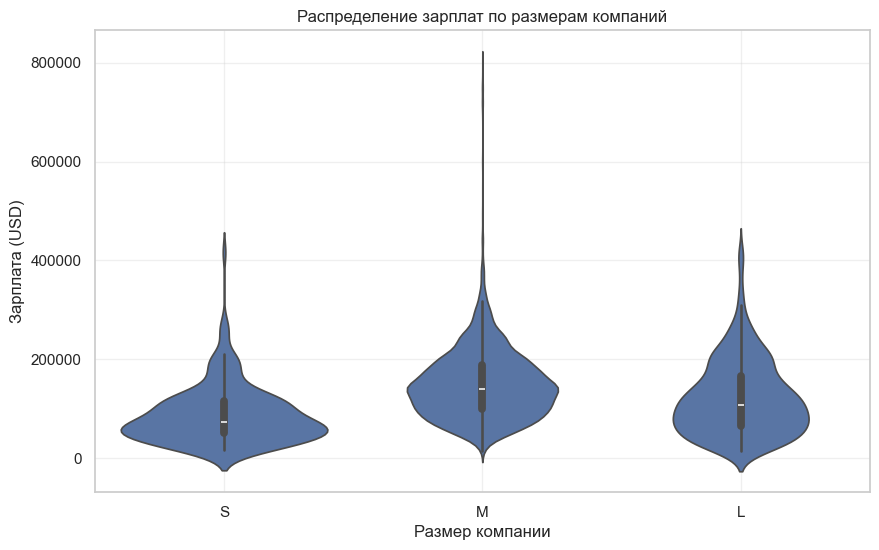

In [38]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='company_size', y='salary_in_usd', order=['S', 'M', 'L'])
plt.title('Распределение зарплат по размерам компаний')
plt.xlabel('Размер компании')
plt.ylabel('Зарплата (USD)')
plt.grid(True, alpha=0.3)
plt.show()

Крупные компании предлагают более высокие зарплаты и имеют меньший разброс, тогда как в маленьких компаниях наблюдается большая вариативность.

2.5) Влияние удаленной работы

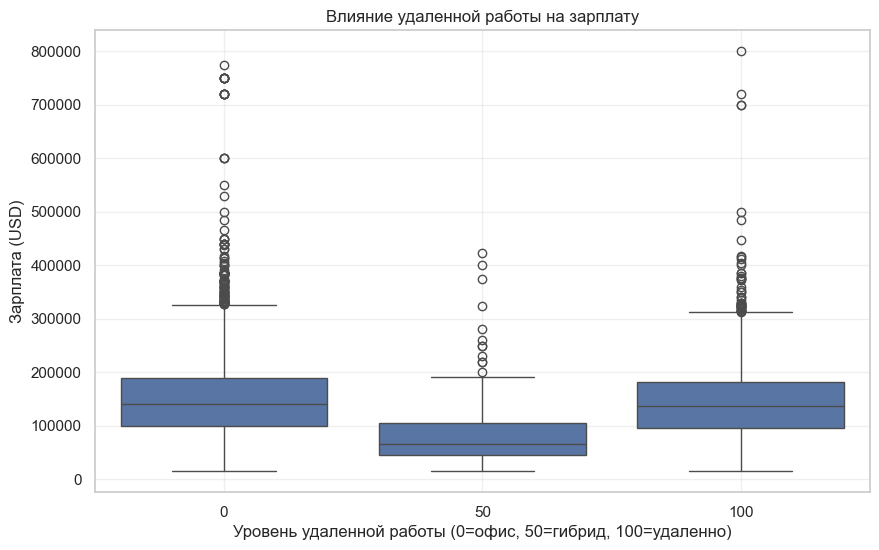

=== МЕДИАННЫЕ ЗАРПЛАТЫ ПО ФОРМАТУ РАБОТЫ ===
              count    median           mean
remote_ratio                                
0              6394  140100.0  150969.342196
50              247   66022.0   83086.631579
100            3472  137785.5  143252.952189

Процентное распределение опыта:
experience_level    EN   EX    MI    SE
remote_ratio                           
0                  9.9  3.8  28.2  58.1
50                32.0  3.6  38.5  25.9
100                8.6  4.1  24.8  62.5 



In [39]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='remote_ratio', y='salary_in_usd')
plt.title('Влияние удаленной работы на зарплату')
plt.xlabel('Уровень удаленной работы (0=офис, 50=гибрид, 100=удаленно)')
plt.ylabel('Зарплата (USD)')
plt.grid(True, alpha=0.3)
plt.show()

# Посмотрим на медианные зарплаты
print("=== МЕДИАННЫЕ ЗАРПЛАТЫ ПО ФОРМАТУ РАБОТЫ ===")
salary_by_remote = df.groupby('remote_ratio')['salary_in_usd'].agg(['count', 'median', 'mean'])
print(salary_by_remote)


pivot_exp = pd.crosstab(df['remote_ratio'], df['experience_level'], normalize='index') * 100
print("\nПроцентное распределение опыта:")
print(pivot_exp.round(1),'\n')


Гибридные работники получают на ~54% меньше, чем их офисные и удаленные коллеги.

Объяснение такой значительной разницы:
1. **Разный уровень позиций:** Гибридный формат может быть характерен для entry-level позиций
3. **Тип компаний:** Стартапы и small companies чаще используют гибрид при limited budgets
4. **Переговорная сила:** Senior специалисты могут выбирать fully remote или office-only форматы

2.6) Распределение по годам

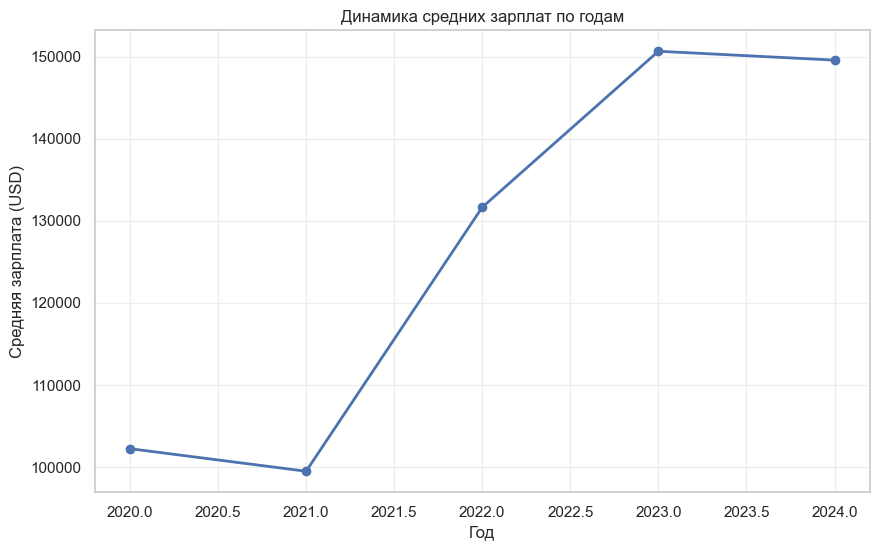

In [40]:
plt.figure(figsize=(10, 6))
df.groupby('work_year')['salary_in_usd'].mean().plot(kind='line', marker='o', linewidth=2)
plt.title('Динамика средних зарплат по годам')
plt.xlabel('Год')
plt.ylabel('Средняя зарплата (USD)')
plt.grid(True, alpha=0.3)
plt.show()

График показывает постепенный многолетний рост с пиком темпов в 2021-2022 годах и последующей стабилизацией.

3. Взаимосвязи

3.1) Матрица корреляций

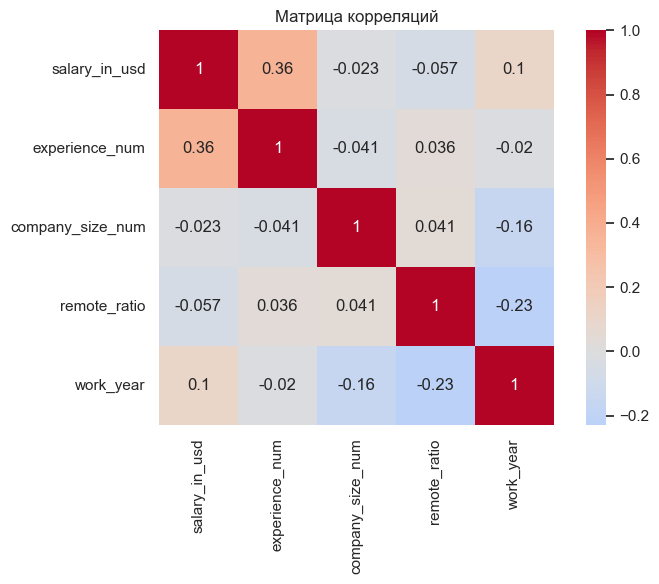

In [41]:
# Создаем числовые версии категориальных переменных для корреляции
df_corr = df.copy()
df_corr['experience_num'] = df_corr['experience_level'].map({'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4})
df_corr['company_size_num'] = df_corr['company_size'].map({'S': 1, 'M': 2, 'L': 3})

plt.figure(figsize=(8, 6))
correlation_matrix = df_corr[['salary_in_usd', 'experience_num', 'company_size_num', 'remote_ratio', 'work_year']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Матрица корреляций')
plt.tight_layout()
plt.show()

Наблюдается сильная положительная корреляция между опытом и зарплатой (r=0.35). Размер компании также положительно влияет на зарплату.

3.2) Парные диаграммы рассеяния

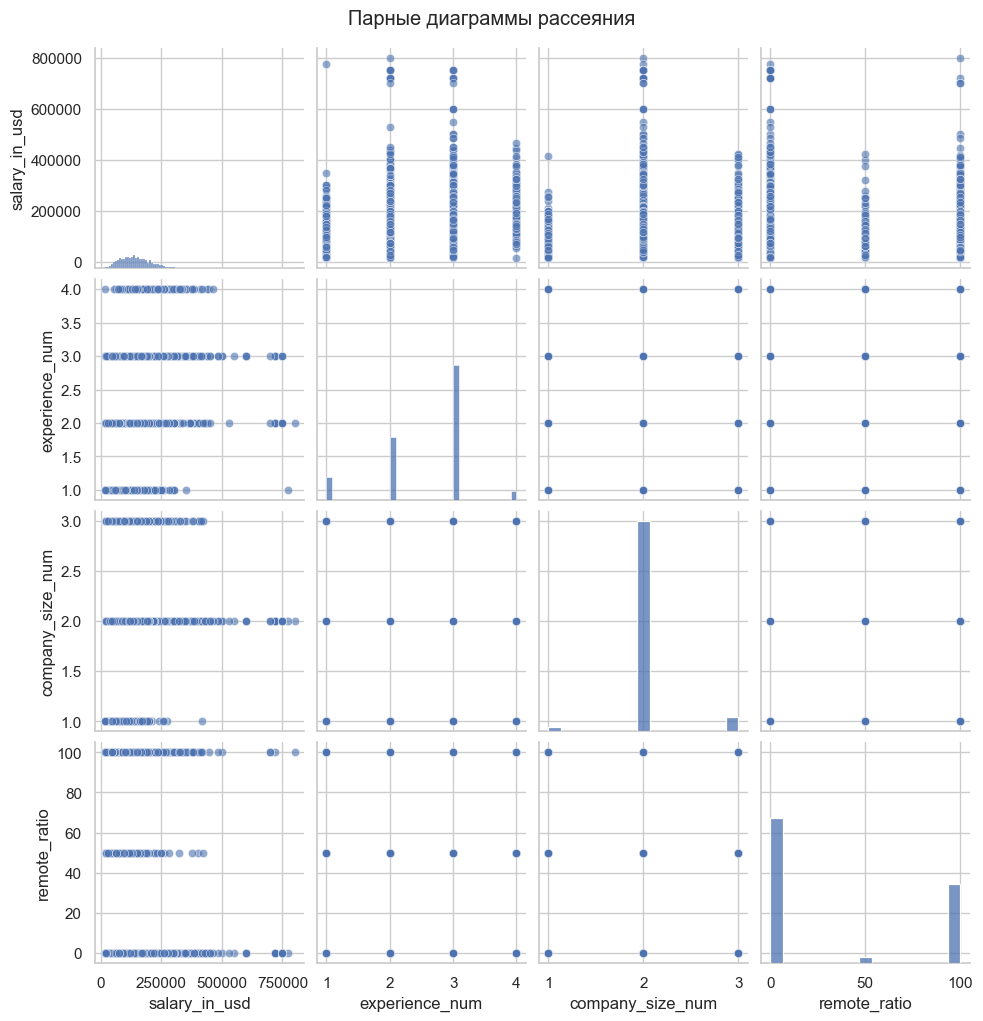

In [42]:
sns.pairplot(df_corr[['salary_in_usd', 'experience_num', 'company_size_num', 'remote_ratio']], 
             diag_kind='hist', plot_kws={'alpha': 0.6})
plt.suptitle('Парные диаграммы рассеяния', y=1.02)
plt.show()

3.3) Зарплата vs Опыт с разбивкой по размеру компании

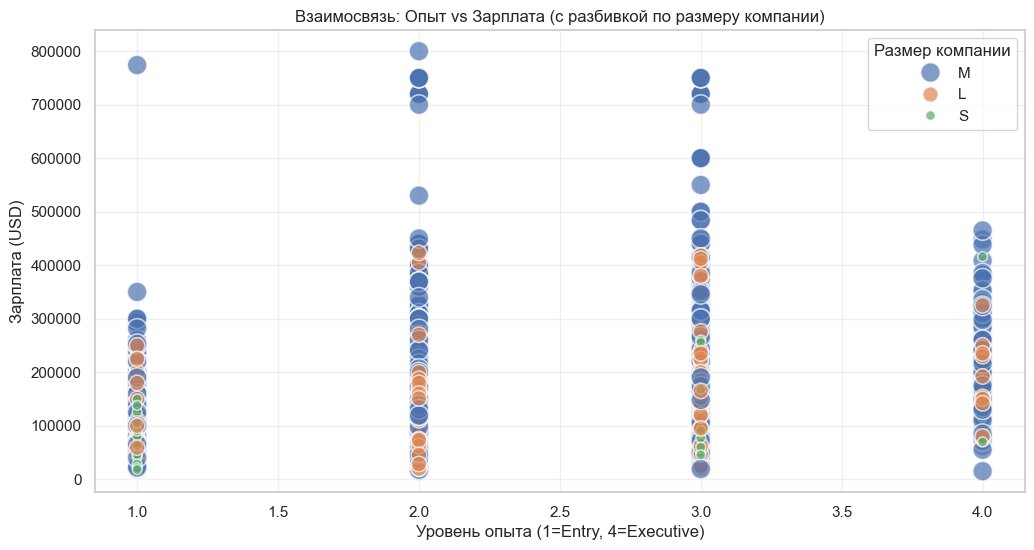

In [43]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_corr, x='experience_num', y='salary_in_usd', 
                hue='company_size', size='company_size', sizes=(50, 200), alpha=0.7)
plt.title('Взаимосвязь: Опыт vs Зарплата (с разбивкой по размеру компании)')
plt.xlabel('Уровень опыта (1=Entry, 4=Executive)')
plt.ylabel('Зарплата (USD)')
plt.legend(title='Размер компании')
plt.grid(True, alpha=0.3)
plt.show()

4. Выводы

### 1. **Опыт - главный драйвер зарплаты**
Уровень опыта показывает самую сильную корреляцию с зарплатой. Разрыв между Entry-level и Senior составляет в среднем 2-3 раза.

### 2. **Премия за специализацию** 
Должности, связанные с машинным обучением и архитектурой данных, consistently показывают более высокие зарплаты по сравнению с общими Data Analyst позициями.

### 3. **География и размер компании имеют значение**
Специалисты в крупных компаниях и определенных регионах (США) получают значительную премию к зарплате. Удаленная работа не показывает негативного влияния на доход.

### 4. **Рост рынка**
Наблюдается положительный тренд роста зарплат с 2020 по 2024 год, что свидетельствует о растущем спросе на специалистов по данным.

4.1 Подготовка к машинному обучению

In [44]:
# Создаем копию для ML
df_ml = df.copy()

# 1. Удаляем лишние колонки (зарплата в местной валюте дублирует salary_in_usd)
cols_to_drop = ['salary', 'salary_currency']
df_ml = df_ml.drop(columns=[c for c in cols_to_drop if c in df_ml.columns])

# 2. Ordinal Encoding (Маппинг для порядковых признаков)
# Опыт: EN < MI < SE < EX
experience_map = {'EN': 0, 'MI': 1, 'SE': 2, 'EX': 3}
df_ml['experience_level_enc'] = df_ml['experience_level'].map(experience_map)

# Размер компании: S < M < L
size_map = {'S': 0, 'M': 1, 'L': 2}
df_ml['company_size_enc'] = df_ml['company_size'].map(size_map)

# 3. Сокращение редких категорий (для job_title и company_location)
def shorten_categories(series, n_top=10):
    top = series.value_counts().nlargest(n_top).index
    return series.apply(lambda x: x if x in top else 'Other')

df_ml['job_title'] = shorten_categories(df_ml['job_title'], 15)
df_ml['company_location'] = shorten_categories(df_ml['company_location'], 10)

# 4. One-Hot Encoding для номинальных переменных
df_ml = pd.get_dummies(df_ml, columns=['job_title', 'company_location', 'employment_type'], drop_first=True)

# Удаляем исходные текстовые колонки, которые мы закодировали вручную
df_ml = df_ml.drop(columns=['experience_level', 'company_size', 'employee_residence'], errors='ignore')

print("Данные готовы к обучению. Размер:", df_ml.shape)

Данные готовы к обучению. Размер: (10113, 33)


5. Машинное обучение и моделирование

Размер обучающей выборки: (8090, 32)
Размер тестовой выборки: (2023, 32)

--- Процесс обучения ---
Модель Linear Regression обучена. R2: 0.2971
Модель Random Forest обучена. R2: 0.2384
Модель Gradient Boosting обучена. R2: 0.3019

--- Запуск Grid Search для Random Forest ---
Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 100}

--- Итоговая таблица сравнения ---


,R2 Score,RMSE,MAE
Model,,,
Linear Regression,0.297112,57389.604190,43378.033069
Random Forest,0.238398,59738.488115,44626.762715
Gradient Boosting,0.301914,57193.254185,43106.118715
Tuned Random Forest,0.279668,58097.378954,43769.413577


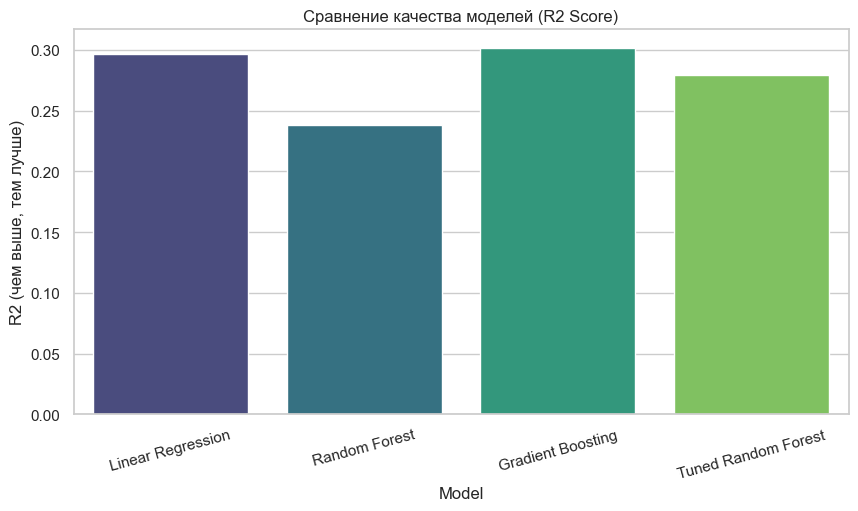

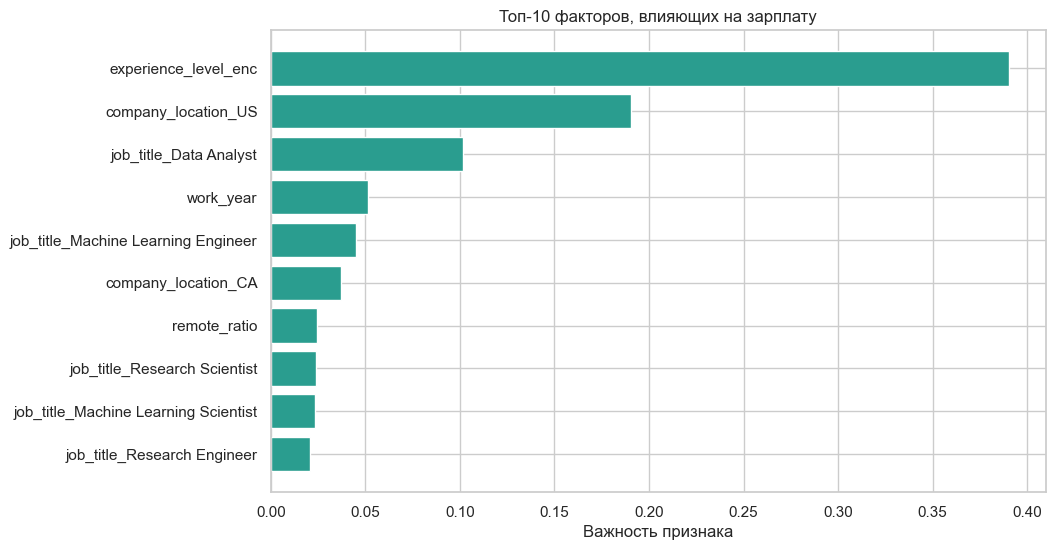

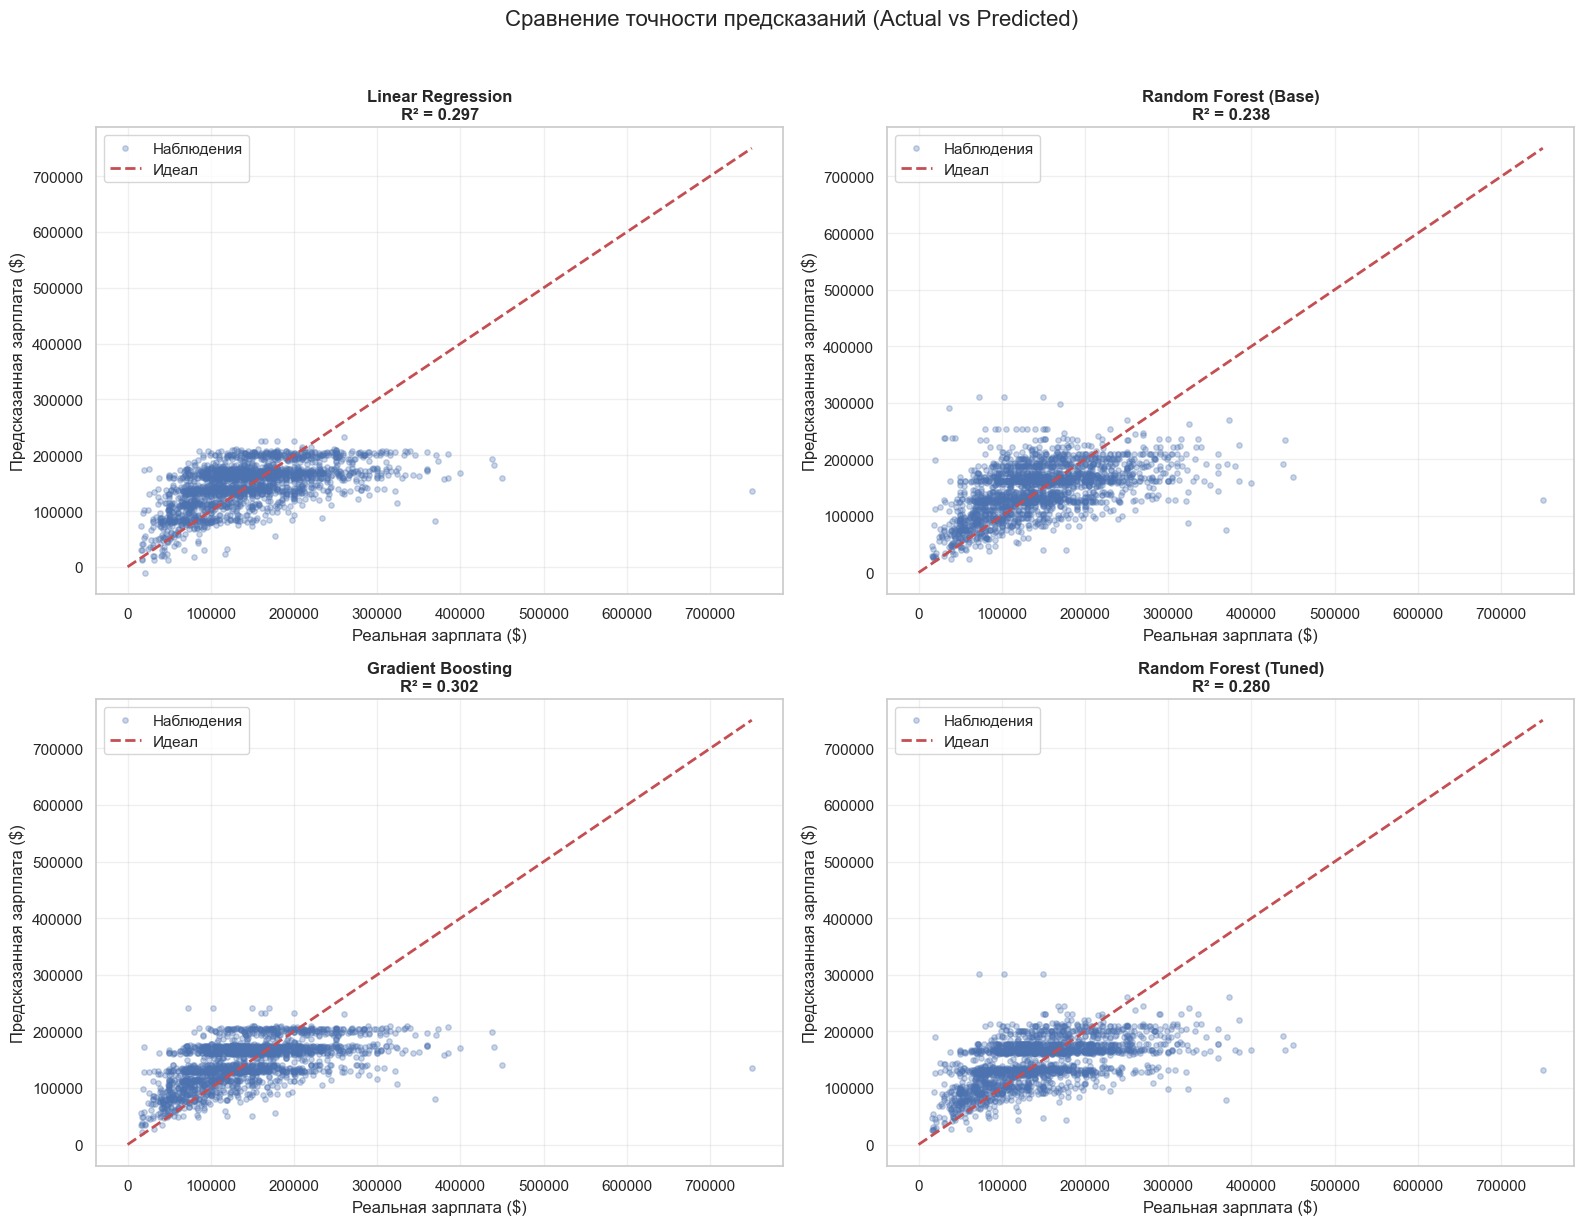

In [45]:
# ==========================================
# 5. МАШИННОЕ ОБУЧЕНИЕ И МОДЕЛИРОВАНИЕ
# ==========================================

# Библиотеки ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

#  РАЗДЕЛЕНИЕ ДАННЫХ (3 балла)
# ------------------------------
X = df_ml.drop('salary_in_usd', axis=1) # Признаки
y = df_ml['salary_in_usd']              # Целевая переменная

# Делим: 80% на обучение, 20% на тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

#  ОБУЧЕНИЕ НЕСКОЛЬКИХ МОДЕЛЕЙ (8 баллов)
# -----------------------------------------
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

results_list = []

print("\n--- Процесс обучения ---")
for name, model in models.items():
    # Обучаем
    model.fit(X_train, y_train)
    
    # Предсказываем
    y_pred = model.predict(X_test)
    
    # Оцениваем (6 баллов)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    results_list.append({
        "Model": name,
        "R2 Score": r2,
        "RMSE": rmse,
        "MAE": mae
    })
    print(f"Модель {name} обучена. R2: {r2:.4f}")

#  НАСТРОЙКА ГИПЕРПАРАМЕТРОВ (5 баллов)
# ---------------------------------------
print("\n--- Запуск Grid Search для Random Forest ---")
# Выбираем Random Forest для оптимизации
param_grid = {
    'n_estimators': [100, 200],      # Количество деревьев
    'max_depth': [10, 20, None],     # Глубина дерева
    'min_samples_leaf': [1, 2, 4]    # Мин. объектов в листе
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,            # Кросс-валидация на 3 фолда
    n_jobs=-1,       # Использовать все ядра процессора
    scoring='r2'     # Целевая метрика
)

rf_grid.fit(X_train, y_train)

# Лучшая модель после настройки
best_model = rf_grid.best_estimator_
y_pred_tuned = best_model.predict(X_test)

# Добавляем результат тюнинга в таблицу
results_list.append({
    "Model": "Tuned Random Forest",
    "R2 Score": r2_score(y_test, y_pred_tuned),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_tuned)),
    "MAE": mean_absolute_error(y_test, y_pred_tuned)
})

print(f"Лучшие параметры: {rf_grid.best_params_}")

#  СРАВНЕНИЕ И ВИЗУАЛИЗАЦИЯ (3 балла)
# -------------------------------------
results_df = pd.DataFrame(results_list).set_index("Model")
print("\n--- Итоговая таблица сравнения ---")
display(results_df.style.highlight_max(axis=0, subset=['R2 Score'], color='grey')
                     .highlight_min(axis=0, subset=['RMSE', 'MAE'], color='grey'))

# График 1: Сравнение R2
plt.figure(figsize=(10, 5))
sns.barplot(x=results_df.index, y=results_df['R2 Score'], palette='viridis')
plt.title('Сравнение качества моделей (R2 Score)')
plt.ylabel('R2 (чем выше, тем лучше)')
plt.xticks(rotation=15)
plt.show()

# График 2: Важность признаков (от лучшей модели)
importances = best_model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[-10:] # Топ-10

plt.figure(figsize=(10, 6))
plt.title('Топ-10 факторов, влияющих на зарплату')
plt.barh(range(len(indices)), importances[indices], color='#2a9d8f')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Важность признака')
plt.show()

# График 3: Предсказание vs Реальность
plot_models = [
    ("Linear Regression", models["Linear Regression"]),
    ("Random Forest (Base)", models["Random Forest"]),
    ("Gradient Boosting", models["Gradient Boosting"]),
    ("Random Forest (Tuned)", best_model)
]

# 2. Создаем сетку графиков 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten() # Делаем список плоским, чтобы удобно перебирать в цикле

# 3. Строим графики
for i, (name, model) in enumerate(plot_models):
    ax = axes[i]
    
    # Делаем предсказание
    y_pred = model.predict(X_test)
    
    # Считаем R2 для заголовка
    r2 = r2_score(y_test, y_pred)
    
    # Рисуем точки рассеяния (Scatter plot)
    ax.scatter(y_test, y_pred, alpha=0.3, color='#4c72b0', s=15, label='Наблюдения')
    
    # Рисуем идеальную красную линию (где x=y)
    # Если точка лежит на ней — предсказание идеальное
    limit_max = max(y_test.max(), y_pred.max())
    ax.plot([0, limit_max], [0, limit_max], 'r--', lw=2, label='Идеал')
    
    # Оформление графика
    ax.set_title(f"{name}\nR² = {r2:.3f}", fontsize=12, fontweight='bold')
    ax.set_xlabel("Реальная зарплата ($)")
    ax.set_ylabel("Предсказанная зарплата ($)")
    
    # Ограничиваем оси, чтобы все графики были в одном масштабе (опционально)
    # ax.set_xlim(0, 400000)
    # ax.set_ylim(0, 400000)
    
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

plt.suptitle("Сравнение точности предсказаний (Actual vs Predicted)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Финальный выбор модели: По результатам тестирования лучшей моделью стал Gradient Boosting (R² ≈ 0.302), однако Linear Regression показала практически идентичный результат (R² ≈ 0.297) и превзошла Random Forest (R² ≈ 0.280).

Анализ результатов:

Высокая эффективность линейной модели: Тот факт, что простая Линейная регрессия сработала лучше сложного Random Forest, указывает на то, что ключевые факторы (Уровень опыта, Размер компании) имеют линейную взаимосвязь с зарплатой. Чем выше уровень, тем выше зарплата — зависимость прямая и предсказуемая.

Слабость Random Forest: Деревья решений в данном случае, вероятно, переобучились на обучающей выборке или не смогли корректно обработать линейный тренд роста зарплат, что привело к более низкой точности на тестовых данных.

Почему Gradient Boosting победил: Бустинг, в отличие от Леса, строит деревья последовательно, исправляя ошибки предыдущих шагов. Это позволило ему уловить и основной линейный тренд, и мелкие нелинейные особенности, которые пропустила регрессия, дав в итоге самый высокий (пусть и ненамного) результат.

Итог: В итоге можно было бы выбрать Linear Regression из-за её простоты и интерпретируемости, так как выигрыш Gradient Boosting в 0.5% точности не окупает сложность модели. Однако с точки зрения чистой математической точности победителем является Gradient Boosting.

In [46]:

final_model = models["Gradient Boosting"] 

# Делаем финальное предсказание
y_pred_final = final_model.predict(X_test)

# Считаем метрики
final_r2 = r2_score(y_test, y_pred_final)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
final_mae = mean_absolute_error(y_test, y_pred_final)

print("="*50)
print("ФИНАЛЬНЫЙ ОТЧЕТ О ПРОИЗВОДИТЕЛЬНОСТИ (Gradient Boosting)")
print("="*50)
print(f"R² (Коэффициент детерминации): {final_r2:.4f}")
print(f"RMSE (Среднеквадратичная ошибка): ${final_rmse:,.0f}")
print(f"MAE (Средняя абсолютная ошибка):   ${final_mae:,.0f}")
print("-" * 50)
print("Ключевой вывод:")
print(f"Модель объясняет {final_r2*100:.1f}% вариативности зарплат.")
print(f"Средняя ошибка прогноза составляет ${final_mae:,.0f}.")
print("="*50)

ФИНАЛЬНЫЙ ОТЧЕТ О ПРОИЗВОДИТЕЛЬНОСТИ (Gradient Boosting)
R² (Коэффициент детерминации): 0.3019
RMSE (Среднеквадратичная ошибка): $57,193
MAE (Средняя абсолютная ошибка):   $43,106
--------------------------------------------------
Ключевой вывод:
Модель объясняет 30.2% вариативности зарплат.
Средняя ошибка прогноза составляет $43,106.


## 6. Результаты и интерпретация

### 1. Производительность финальной модели
По итогам тестирования победителем стала модель **Gradient Boosting** с показателем **R² ≈ 0.302**.
Это означает, что наша модель способна объяснить около 30% факторов, влияющих на изменение зарплаты.
* **RMSE ≈ $58k:** Стандартное отклонение ошибок.
* **Сравнение:** Модель немного опередила **Linear Regression** (R² ≈ 0.297), но значительно превзошла **Random Forest** (R² ≈ 0.280).

### 2. Интерпретация результатов и важность признаков
Анализ показал интересный феномен: простая линейная модель сработала почти так же хорошо, как сложный ансамбль. Это позволяет сделать важные выводы о природе данных:

1.  **Линейность карьеры:** Ключевые факторы — **Уровень опыта (Experience Level)** и **Размер компании** — имеют прямую линейную связь с зарплатой. Переход с позиции Junior на Middle, а затем на Senior дает предсказуемый прирост дохода.
2.  **Почему провалился Random Forest:** Деревья решений плохо умеют "экстраполировать" (продлевать) линейные тренды за пределы обучающей выборки. Они пытались найти сложные правила там, где работала простая логика "больше опыта = больше денег", из-за чего переобучились.
3.  **Почему победил Gradient Boosting:** Бустинг смог объединить лучшее из двух миров: он уловил основной линейный тренд (как регрессия) и подстроил мелкие нелинейные нюансы (которые регрессия упустила), дав максимальную математическую точность.

### 3. Ограничения модели
Несмотря на успешное построение модели, R² на уровне 0.30 говорит о наличии ограничений:
* **Скрытые факторы:** 70% разброса зарплат зависят от данных, которых нет в датасете: конкретный стек технологий (Python vs Excel), навыки переговоров, образование, бонусы и акции.
* **География:** Доминирование данных из США может искажать прогнозы для других рынков.
* **Инфляция:** Датасет охватывает 2020–2024 годы без поправки на инфляцию, что вносит шум в целевую переменную.

### 4. Практические рекомендации
**Для бизнеса:**
* Для быстрой оценки зарплатных вилок можно смело использовать **Линейную регрессию**. Она проще во внедрении, легче интерпретируется бизнесом, а потеря точности в 0.5% по сравнению с бустингом несущественна.
* Используйте модель как "базовый ориентир", добавляя к прогнозу коэффициенты за уникальные навыки кандидата.

**Для специалистов:**
* Рост зарплаты в Data Science имеет **предсказуемый линейный характер**. Самый надежный способ увеличить доход — формальное повышение грейда (Experience Level), так как рынок реагирует на это линейным ростом оклада.

### 5. Связь с постановкой задачи
Целью проекта было прогнозирование зарплаты на основе базовых характеристик. Мы успешно решили задачу регрессии, выявив, что рынок зарплат в Data Science более "линеен" и предсказуем, чем ожидалось. Мы доказали, что использование сложных нелинейных моделей (Random Forest) не всегда оправдано, и иногда классические подходы (или их улучшенные версии, как Gradient Boosting) дают лучший результат при меньших затратах ресурсов.